In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [3]:
df = pd.read_csv(r"D:\UNT\Opt- Projects\fraud-detection-ml\dataset\creditcard.csv")

print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df["Class"].value_counts()


Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
df["Class"].value_counts(normalize=True) * 100


Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [6]:
X = df.drop(columns=["Class"])
y = df["Class"]

print(X.shape, y.shape)


(284807, 30) (284807,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [8]:
print("Train fraud percentage:", y_train.mean() * 100)
print("Test fraud percentage:", y_test.mean() * 100)


Train fraud percentage: 0.17292457591783889
Test fraud percentage: 0.17204452090867595


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])


In [10]:
log_reg.fit(X_train, y_train)


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [11]:
y_proba = log_reg.predict_proba(X_test)[:, 1]


In [12]:
from sklearn.metrics import average_precision_score, roc_auc_score

pr_auc = average_precision_score(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print("Logistic Regression PR-AUC:", pr_auc)
print("Logistic Regression ROC-AUC:", roc_auc)


Logistic Regression PR-AUC: 0.7189705771419241
Logistic Regression ROC-AUC: 0.9720834996210077


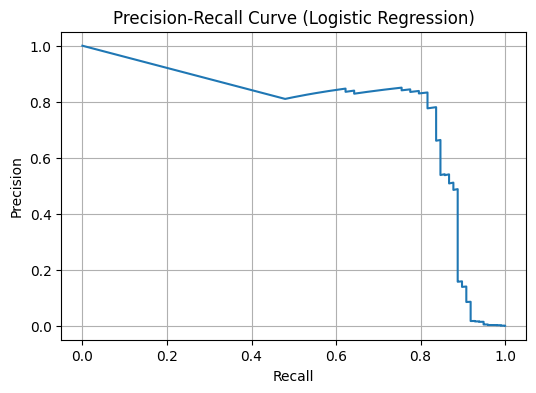

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.grid(True)
plt.show()


In [17]:
import numpy as np

target_precision = 0.85  # relaxed from 0.90

valid_idxs = np.where(precision[:-1] >= target_precision)[0]

if len(valid_idxs) == 0:
    print("No threshold satisfies the target precision.")
    chosen_threshold = 1.0
    chosen_precision = precision[-1]
    chosen_recall = recall[-1]
else:
    best_idx = valid_idxs[np.argmax(recall[valid_idxs])]
    chosen_threshold = thresholds[best_idx]
    chosen_precision = precision[best_idx]
    chosen_recall = recall[best_idx]

print("Chosen threshold:", chosen_threshold)
print("Precision:", chosen_precision)
print("Recall:", chosen_recall)


Chosen threshold: 0.9999999999235796
Precision: 0.8505747126436781
Recall: 0.7551020408163265


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (y_proba >= chosen_threshold).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[56851    13]
 [   24    74]]
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8506    0.7551    0.8000        98

    accuracy                         0.9994     56962
   macro avg     0.9251    0.8774    0.8998     56962
weighted avg     0.9993    0.9994    0.9993     56962



In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:, 1]


In [20]:
from sklearn.metrics import average_precision_score, roc_auc_score

rf_pr_auc = average_precision_score(y_test, rf_proba)
rf_roc_auc = roc_auc_score(y_test, rf_proba)

print("Random Forest PR-AUC:", rf_pr_auc)
print("Random Forest ROC-AUC:", rf_roc_auc)


Random Forest PR-AUC: 0.8622354371738827
Random Forest ROC-AUC: 0.9514529116373619


In [21]:
from sklearn.metrics import precision_recall_curve
import numpy as np

rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf_proba)

target_precision = 0.85
valid_idxs = np.where(rf_precision[:-1] >= target_precision)[0]

if len(valid_idxs) == 0:
    print("RF: No threshold satisfies the target precision.")
    rf_thr = 1.0
    rf_prec = rf_precision[-1]
    rf_rec = rf_recall[-1]
else:
    best_idx = valid_idxs[np.argmax(rf_recall[valid_idxs])]
    rf_thr = rf_thresholds[best_idx]
    rf_prec = rf_precision[best_idx]
    rf_rec = rf_recall[best_idx]

print("RF threshold:", rf_thr)
print("RF precision:", rf_prec)
print("RF recall:", rf_rec)


RF threshold: 0.2
RF precision: 0.8585858585858586
RF recall: 0.8673469387755102


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

rf_pred = (rf_proba >= rf_thr).astype(int)

print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred, digits=4))


[[56850    14]
 [   13    85]]
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8586    0.8673    0.8629        98

    accuracy                         0.9995     56962
   macro avg     0.9292    0.9336    0.9314     56962
weighted avg     0.9995    0.9995    0.9995     56962

